In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import os

In [9]:
data_root = '.'
train = pd.read_csv(os.path.join(data_root, "train.csv"))
test = pd.read_csv(os.path.join(data_root, "test.csv"))
train.info(), test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3215 entries, 0 to 3214
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  3215 non-null   object
 1   label     3215 non-null   object
dtypes: object(2)
memory usage: 50.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732 entries, 0 to 1731
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1732 non-null   object
dtypes: object(1)
memory usage: 13.7+ KB


(None, None)

In [3]:
train[:10]

,image_id,label
0,train_1a,rice
1,train_1b,candy
2,train_1c,jam
3,train_1d,coffee
4,train_2a,vinegar
5,train_2b,chocolate
6,train_2c,sugar
7,train_2d,water
8,train_3a,juice
9,train_3b,candy


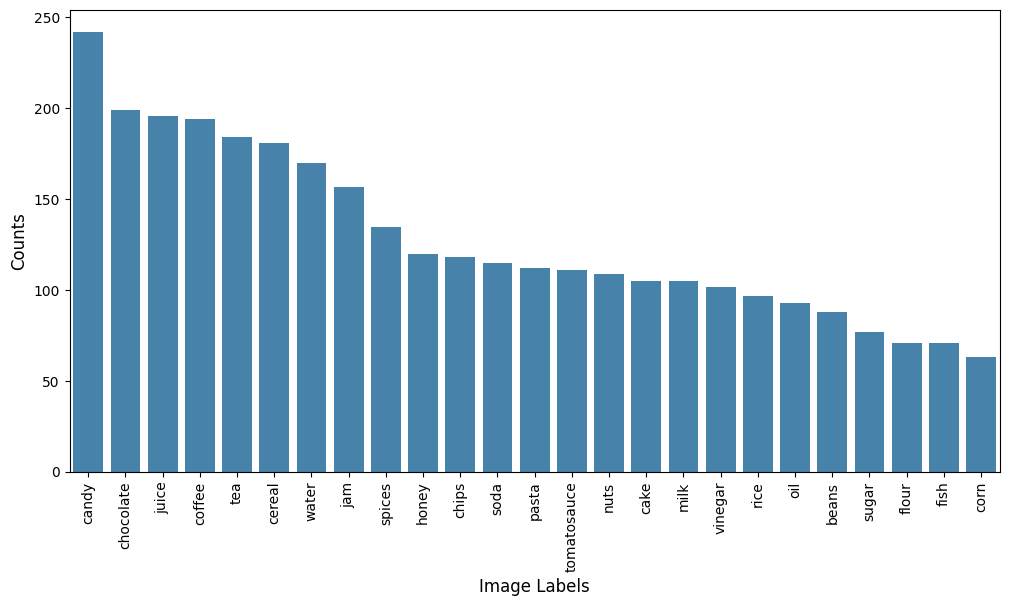

In [4]:
label_counts = train.label.value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(label_counts, alpha=0.9)
plt.xticks(rotation = 'vertical')
plt.xlabel('Image Labels', fontsize = 12)
plt.ylabel('Counts', fontsize=12)
plt.show()

In [5]:
(sum(train.label.value_counts()))/ len(train.label.value_counts())

128.6

In [8]:
train.iloc[1, 0], train.iloc[1, 1]

('train_1b', 'candy')

In [40]:
train_img_path = os.path.join(data_root, 'train_img')
test_img_path = os.path.join(data_root, 'test_img')
os.listdir(train_img_path)[:5]

['train_445a.png',
 'train_432c.png',
 'train_275b.png',
 'train_653d.png',
 'train_625b.png']

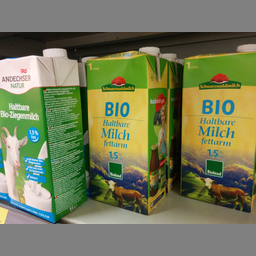

In [ ]:
sample_img = Image.open(os.path.join(train_img_path, 'train_445a.png'))
sample_img